# Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from ucimlrepo import fetch_ucirepo
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

# Setup

In [65]:
config_file = open("config.json")
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"]

In [66]:
config_file = open("visual_config.json")
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Get Dataset

In [67]:
dataset = pd.read_csv("datasets/DARWIN.csv", header=0)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [68]:
X

ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0      id_1       5160     0.000013    120.804174       86.853334   
1      id_2      51980     0.000016    115.318238       83.448681   
2      id_3       2600     0.000010    229.933997      172.761858   
3      id_4       2130     0.000010    369.403342      183.193104   
4      id_5       2310     0.000007    257.997131      111.275889   
..      ...        ...          ...           ...             ...   
169  id_170       2930     0.000010    241.736477      176.115957   
170  id_171       2140     0.000009    274.728964      234.495802   
171  id_172       3830     0.000008    151.536989      171.104693   
172  id_173       1760     0.000008    289.518195      196.411138   
173  id_174       2875     0.000008    235.769350      178.208024   

     max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0                 957              6601          0.361800            0.217459   
1                1694              6998          0.272513            0.144880   
2                2333              5802          0.387020            0.181342   
3                1756              8159          0.556879            0.164502   
4                 987              4732          0.266077            0.145104   
..                ...               ...               ...                 ...   
169              1839              6439          0.253347            0.174663   
170              2053              8487          0.225537            0.174920   
171              1287              7352          0.165480            0.161058   
172              1674              6946          0.518937            0.202613   
173              1838              6560          0.567311            0.147818   

     mean_gmrt1  ...  mean_gmrt25  mean_jerk_in_air25  mean_jerk_on_paper25  \
0    103.828754  ...   249.729085            0.141434              0.024471   
1     99.383459  ...    77.258394            0.049663              0.018368   
2    201.347928  ...   193.667018            0.178194              0.017174   
3    276.298223  ...   163.065803            0.113905              0.019860   
4    184.636510  ...   147.094679            0.121782              0.020872   
..          ...  ...          ...                 ...                   ...   
169  208.926217  ...   200.568126            0.119152              0.020909   
170  254.612383  ...   231.243565            0.174495              0.017640   
171  161.320841  ...   177.935566            0.114472              0.017194   
172  242.964666  ...   177.935566            0.114472              0.017194   
173  206.988687  ...   177.935566            0.114472              0.017194   

     mean_speed_in_air25  mean_speed_on_paper25  num_of_pendown25  \
0               5.596487               3.184589                71   
1               1.665973               0.950249               129   
2               4.000781               2.392521                74   
3               4.206746               1.613522               123   
4               3.319036               1.680629                92   
..                   ...                    ...               ...   
169             4.508709               2.233198                96   
170             4.685573               2.806888                84   
171             3.493815               2.510601                88   
172             3.493815               2.510601                88   
173             3.493815               2.510601                88   

     paper_time25  pressure_mean25  pressure_var25  total_time25  
0           40120      1749.278166     296102.7676        144605  
1          126700      1504.768272     278744.2850        298640  
2           45480      1431.443492     144411.7055         79025  
3           67945      1465.843329     230184.7154        181220  
4           37285      1841.702561     158290.0255         72575  
..            ...          

In [69]:
y

0      P
1      P
2      P
3      P
4      P
      ..
169    H
170    H
171    H
172    H
173    H
Name: class, Length: 174, dtype: object

###### Obtain Dataset From Repository

In [70]:
# # fetch dataset 
# darwin = fetch_ucirepo(id=732)
#   
# # data (as pandas dataframes)
# X = darwin.data.features
# y = darwin.data.targets
#   
# # metadata 
# print(darwin.metadata)
# 
# # variable information
# print(darwin.variables)

In [71]:
data_analysis = DatasetAnalysis()

In [72]:
np.unique(y)

array(['H', 'P'], dtype=object)

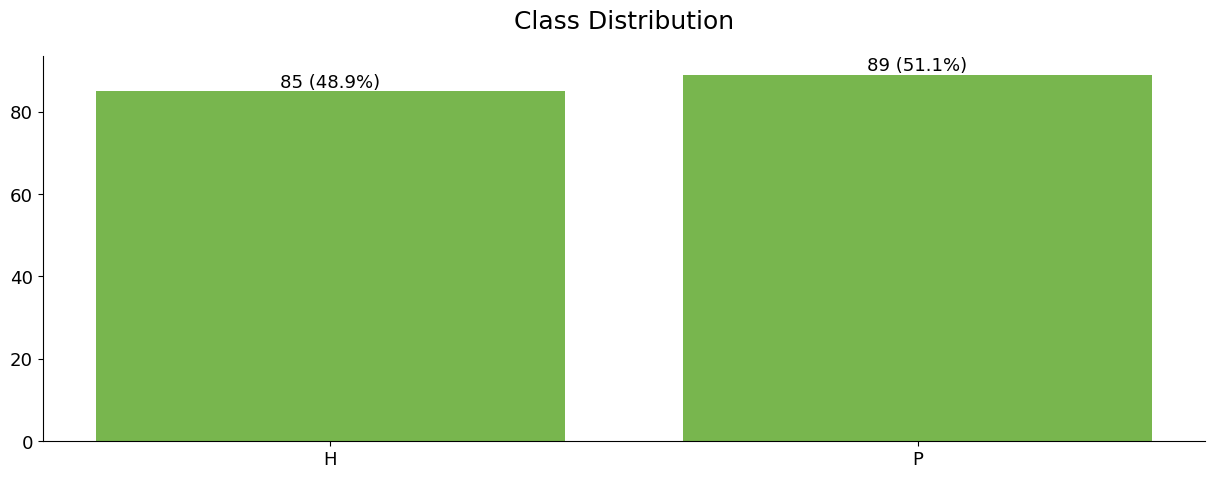

In [73]:
plt.figure(figsize=(15, 5))

data_analysis.class_dist(y, title="Class Distribution", colors=green_color, label_font_size=label_size)

plt.savefig(f"{logs_dir}/darwin_class_dist.png", bbox_inches="tight")
plt.show()

In [74]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [75]:
from sklearn.compose import ColumnTransformer
print(f"Numerical Columns - {len(numerical_columns)}\n\n {numerical_columns}")
print(f"\n\n\nCategorical Columns - {len(categorical_columns)}\n\n {categorical_columns}")

Numerical Columns - 450

 ['air_time1', 'disp_index1', 'gmrt_in_air1', 'gmrt_on_paper1', 'max_x_extension1', 'max_y_extension1', 'mean_acc_in_air1', 'mean_acc_on_paper1', 'mean_gmrt1', 'mean_jerk_in_air1', 'mean_jerk_on_paper1', 'mean_speed_in_air1', 'mean_speed_on_paper1', 'num_of_pendown1', 'paper_time1', 'pressure_mean1', 'pressure_var1', 'total_time1', 'air_time2', 'disp_index2', 'gmrt_in_air2', 'gmrt_on_paper2', 'max_x_extension2', 'max_y_extension2', 'mean_acc_in_air2', 'mean_acc_on_paper2', 'mean_gmrt2', 'mean_jerk_in_air2', 'mean_jerk_on_paper2', 'mean_speed_in_air2', 'mean_speed_on_paper2', 'num_of_pendown2', 'paper_time2', 'pressure_mean2', 'pressure_var2', 'total_time2', 'air_time3', 'disp_index3', 'gmrt_in_air3', 'gmrt_on_paper3', 'max_x_extension3', 'max_y_extension3', 'mean_acc_in_air3', 'mean_acc_on_paper3', 'mean_gmrt3', 'mean_jerk_in_air3', 'mean_jerk_on_paper3', 'mean_speed_in_air3', 'mean_speed_on_paper3', 'num_of_pendown3', 'paper_time3', 'pressure_mean3', 'pressure

The only categorical column is 'ID' which has no relevance for classification because is just an identifier of each experiment, so it will be dropped

In [76]:
X = X.drop(columns=["ID"])
features_names = X.columns

In [77]:
#Convert from pandas to numpy and turn into a 1D array
y = y.to_numpy().ravel()
y = [0 if x == 'H' else 1 for x in y]
y

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [78]:
X_train_pd, X_test_pd, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = X_train_pd.to_numpy()
X_test = X_test_pd.to_numpy()

## Instance to extract local explanations for all models

In [79]:
Exp_index = 3
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]

for i in range(len(Exp_inst_pd)):
    print(f"{Exp_inst_pd.index[i]}  {Exp_inst_pd.iloc[i]}")

print(f"\n\nClass: {Exp_inst_class}")

air_time1  1870.0
disp_index1  6.26e-06
gmrt_in_air1  595.5720139
gmrt_on_paper1  498.8908171
max_x_extension1  2316.0
max_y_extension1  8467.0
mean_acc_in_air1  1.04333271
mean_acc_on_paper1  0.31346397
mean_gmrt1  547.2314155
mean_jerk_in_air1  0.190816102
mean_jerk_on_paper1  0.025585821
mean_speed_in_air1  8.525480606
mean_speed_on_paper1  8.977478544
num_of_pendown1  6.0
paper_time1  2925.0
pressure_mean1  1948.723077
pressure_var1  86732.29596
total_time1  4795.0
air_time2  4180.0
disp_index2  1.22e-05
gmrt_in_air2  50.47602571
gmrt_on_paper2  38.92156783
max_x_extension2  200.0
max_y_extension2  4439.0
mean_acc_in_air2  0.24737
mean_acc_on_paper2  0.082321323
mean_gmrt2  44.69879677
mean_jerk_in_air2  0.036387001
mean_jerk_on_paper2  0.008026825
mean_speed_in_air2  1.283754046
mean_speed_on_paper2  0.772030774
num_of_pendown2  3.0
paper_time2  13355.0
pressure_mean2  1805.642082
pressure_var2  198126.5817
total_time2  17535.0
air_time3  335.0
disp_index3  7.72e-06
gmrt_in_air3  

# Classification

In [80]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [81]:
lr_init_t = time.time()
lr_clf = LogisticRegression(max_iter=500, random_state=42).fit(X_train, Y_train)
lr_fin_t = time.time()
lr_duration = lr_fin_t - lr_init_t

Metrics                Values
accuracy             0.885714
false-positive rate  0.066667
false-negative rate  0.150000
precision            0.944444
recall               0.850000
f-score              0.894737

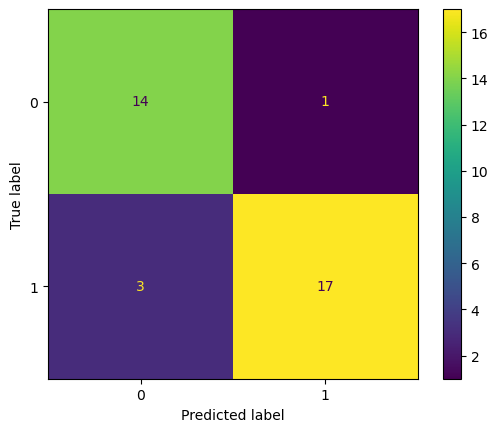

In [82]:
lr_ye = lr_clf.predict(X_test)

lr_cm = confusion_matrix(Y_test, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, lr_ye)

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]

plt.show()

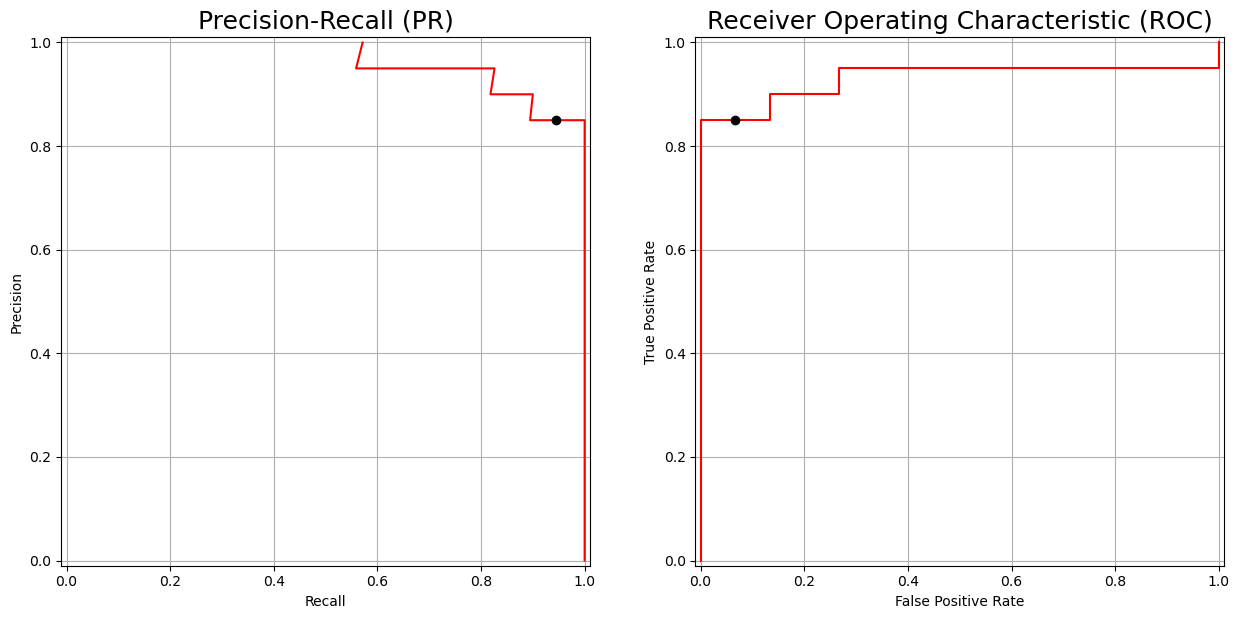

In [83]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(Y_test, lr_cm, lr_y2d)

plt.subplot(1,2,2)
perf_analysis.plot_ROC(Y_test, lr_cm, lr_y2d)

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [84]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [85]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [86]:
shap.initjs()

In [87]:
lr_shap_init_t = time.time()
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

In [88]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [89]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/35 [00:00<?, ?it/s]

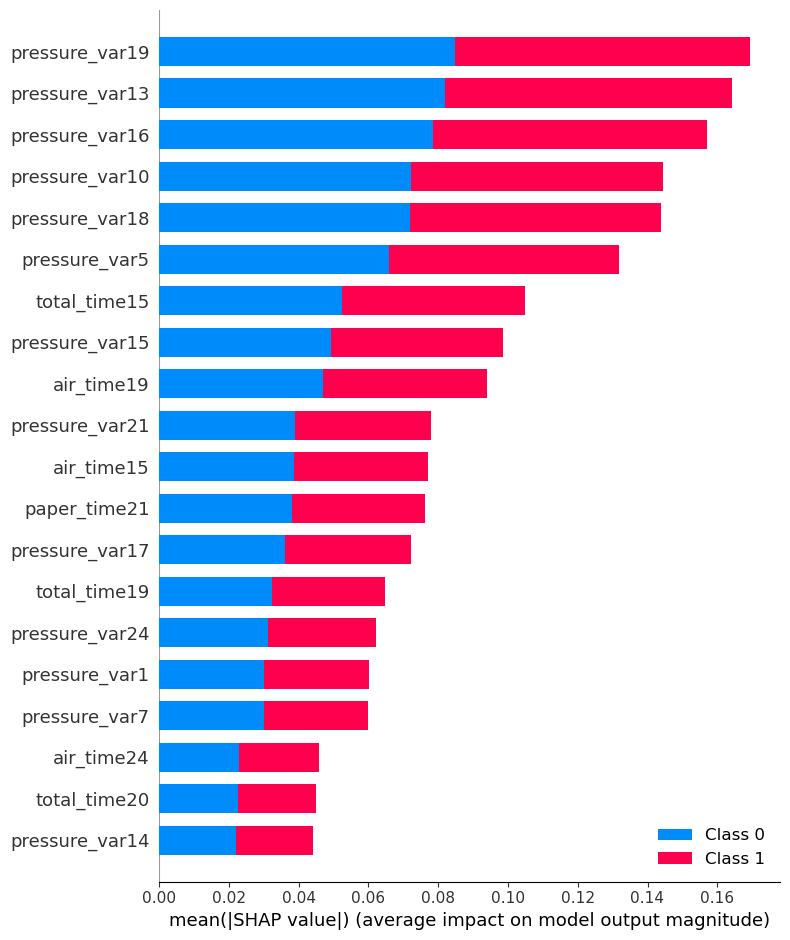

In [90]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar")
lr_shap_fin_t = time.time()
lr_shap_dur = lr_shap_fin_t - lr_shap_init_t

## <i>Random Forest</i> (RF)

In [91]:
rf_init_t = time.time()
rf_clf = RandomForestClassifier(random_state=42).fit(X_train, Y_train)
rf_fin_t = time.time()
rf_duration = rf_fin_t - rf_init_t

Metrics                Values
accuracy             0.885714
false-positive rate  0.066667
false-negative rate  0.150000
precision            0.944444
recall               0.850000
f-score              0.894737

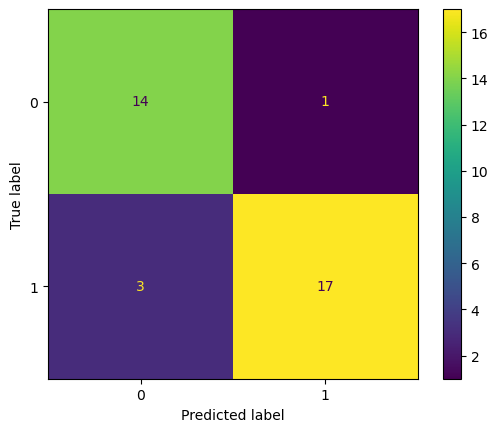

In [92]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
rf_metrics = perf_analysis.compute_metrics(rf_cm)
display(rf_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, rf_ye)

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]

plt.show()

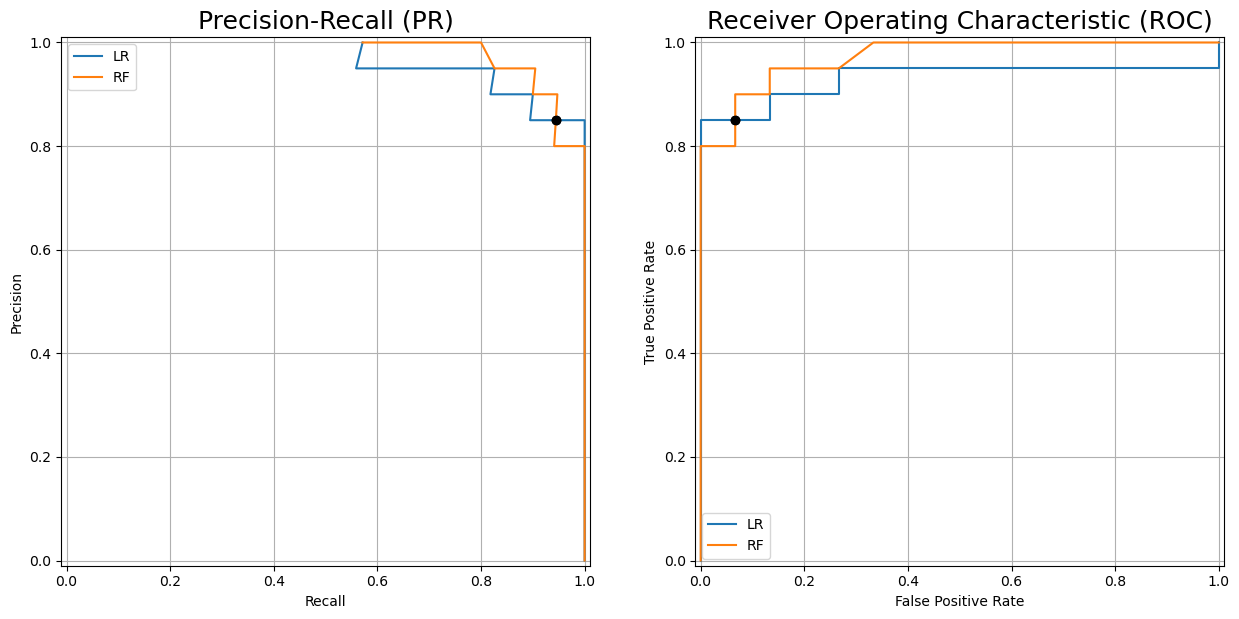

In [93]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR","RF"])


plt.show()

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [94]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [95]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [96]:
rf_shap_init_t = time.time()
rf_SHAP_exp = shap.TreeExplainer(rf_clf, random_state=42)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [97]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [98]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)

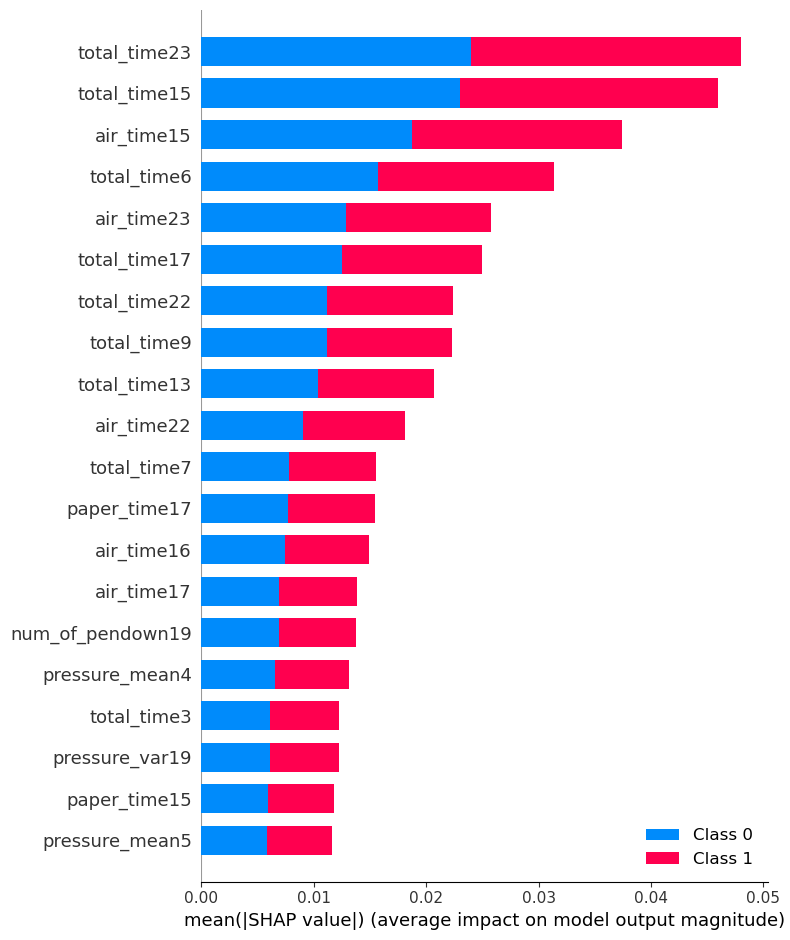

In [99]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar")
rf_shap_fin_t = time.time()
rf_shap_dur = rf_shap_fin_t - rf_shap_init_t

## <i> Support Vector Machines</i> (SVM)

In [100]:
#(probability=True) gives the possibility to use the predict_proba() method, which is used to extract explanations
svm_init_t = time.time()
svm_clf = SVC(kernel="linear", probability=True, random_state=42).fit(X_train, Y_train)
svm_fin_t = time.time()
svm_duration = svm_fin_t - svm_init_t

Metrics                Values
accuracy             0.857143
false-positive rate  0.133333
false-negative rate  0.150000
precision            0.894737
recall               0.850000
f-score              0.871795

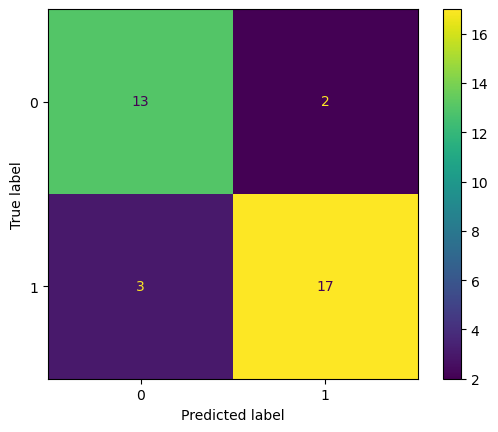

In [101]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
svm_metrics = perf_analysis.compute_metrics(svm_cm)
display(svm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, svm_ye)

svm_y2d = svm_clf.decision_function(X_test)

plt.show()

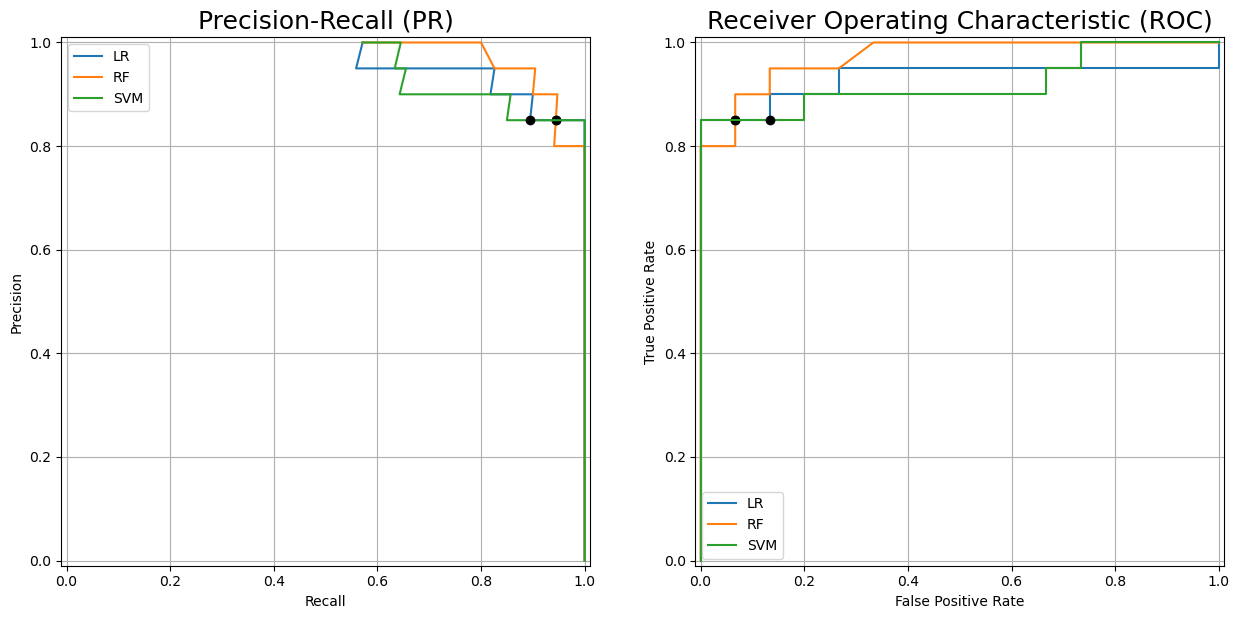

In [102]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [103]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [104]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [105]:
svm_shap_init_t = time.time()
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [106]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [107]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)

  0%|          | 0/35 [00:00<?, ?it/s]

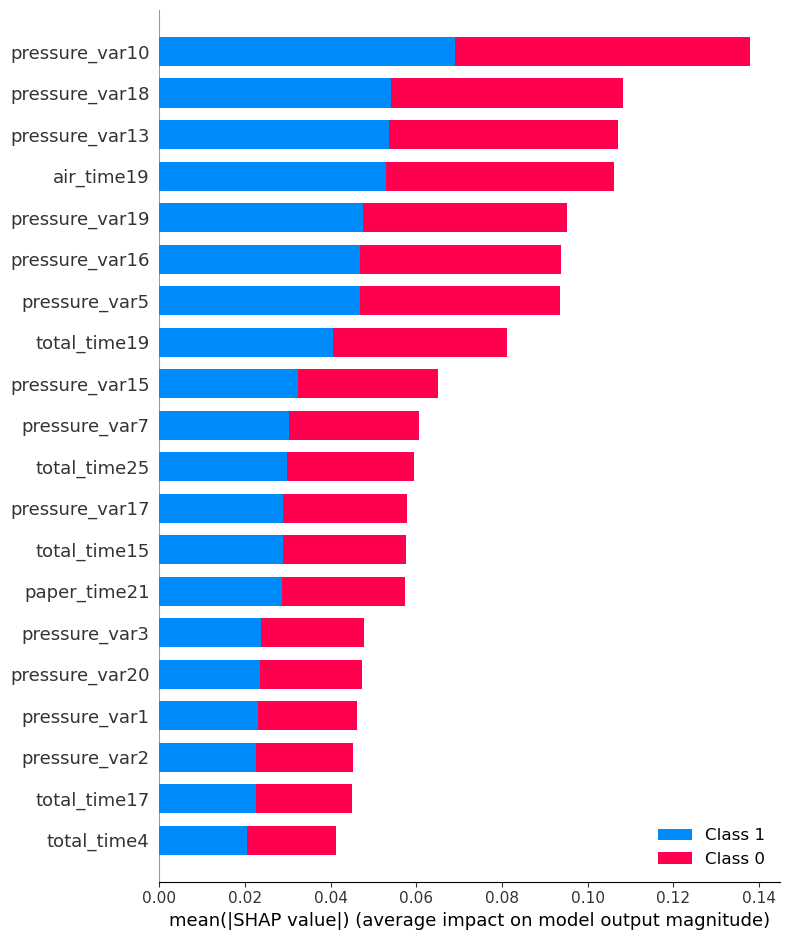

In [108]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar")
svm_shap_fin_t = time.time()
svm_shap_dur = svm_shap_fin_t - svm_shap_init_t

## <i>Explainable Boosting Machine</i> (EBM)

In [109]:
ebm_init_t = time.time()
ebm_clf = ExplainableBoostingClassifier(random_state=42).fit(X_train_pd, Y_train)
ebm_fin_t = time.time()
ebm_duration = ebm_fin_t - ebm_init_t

Metrics                Values
accuracy             0.885714
false-positive rate  0.066667
false-negative rate  0.150000
precision            0.944444
recall               0.850000
f-score              0.894737

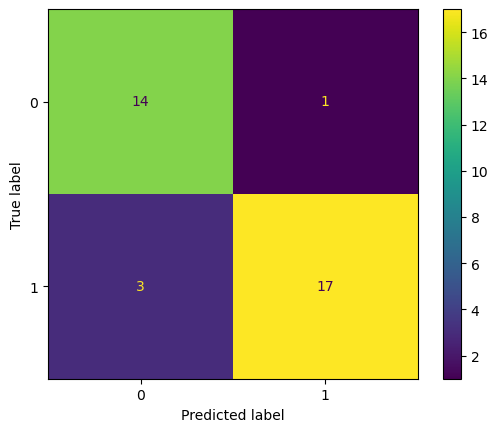

In [110]:
ebm_ye = ebm_clf.predict(X_test_pd)

ebm_cm = confusion_matrix(Y_test, ebm_ye)
ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
display(ebm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, ebm_ye)

ebm_y2d = ebm_clf.decision_function(X_test)

plt.show()

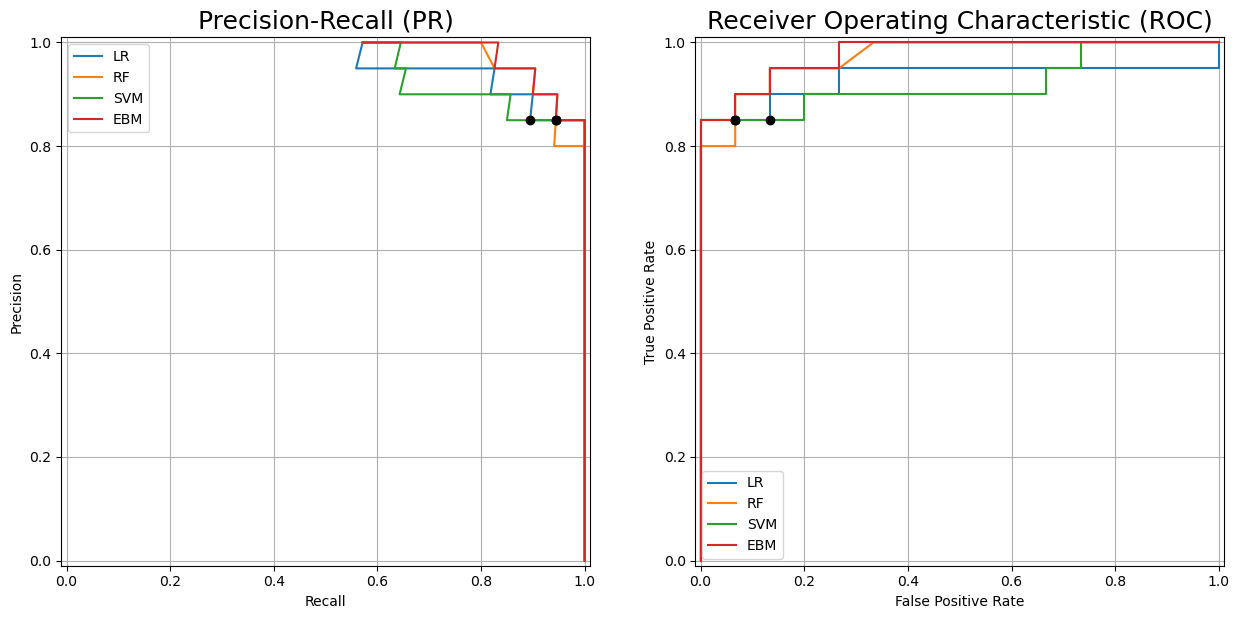

In [111]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.show()

### Extract Explanations

#### Local

In [112]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2869416235152/ -->

#### Global

In [113]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2869077465040/ -->

# Summary

In [114]:
visual = Visualization()

## Time

In [115]:
time_pd_cols = ["LR", "RF", "SVM", "EBM"]
fit_durs = [round(x, 1) for x in [lr_duration, rf_duration, svm_duration, ebm_duration]]
shap_durs = [round(x, 1) for x in [lr_shap_dur, rf_shap_dur, svm_shap_dur]]
pd_vals = [fit_durs, shap_durs]

duration_summary = pd.DataFrame(pd_vals, columns=time_pd_cols, index=["Fit", "SHAP"])
duration_summary.columns.names = ["Task"]
duration_summary

Task    LR   RF   SVM   EBM
Fit    0.1  0.3   0.0  55.9
SHAP  91.7  0.4  99.4   NaN

In [116]:
latex_str = duration_summary.columns.name + "".join([" & " + x for x in duration_summary.columns]) + " \\\ \n"
for i, row in duration_summary.iterrows():

    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/darwin_duration.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Metrics

In [117]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
display(overall_metrics)

Metrics                LR    RF   SVM   EBM
accuracy             0.89  0.89  0.86  0.89
false-positive rate  0.07  0.07  0.13  0.07
false-negative rate  0.15  0.15  0.15  0.15
precision            0.94  0.94  0.89  0.94
recall               0.85  0.85  0.85  0.85
f-score              0.89  0.89  0.87  0.89

##### Build LaTeX table format

In [118]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [119]:
for i, row in overall_metrics.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/darwin_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

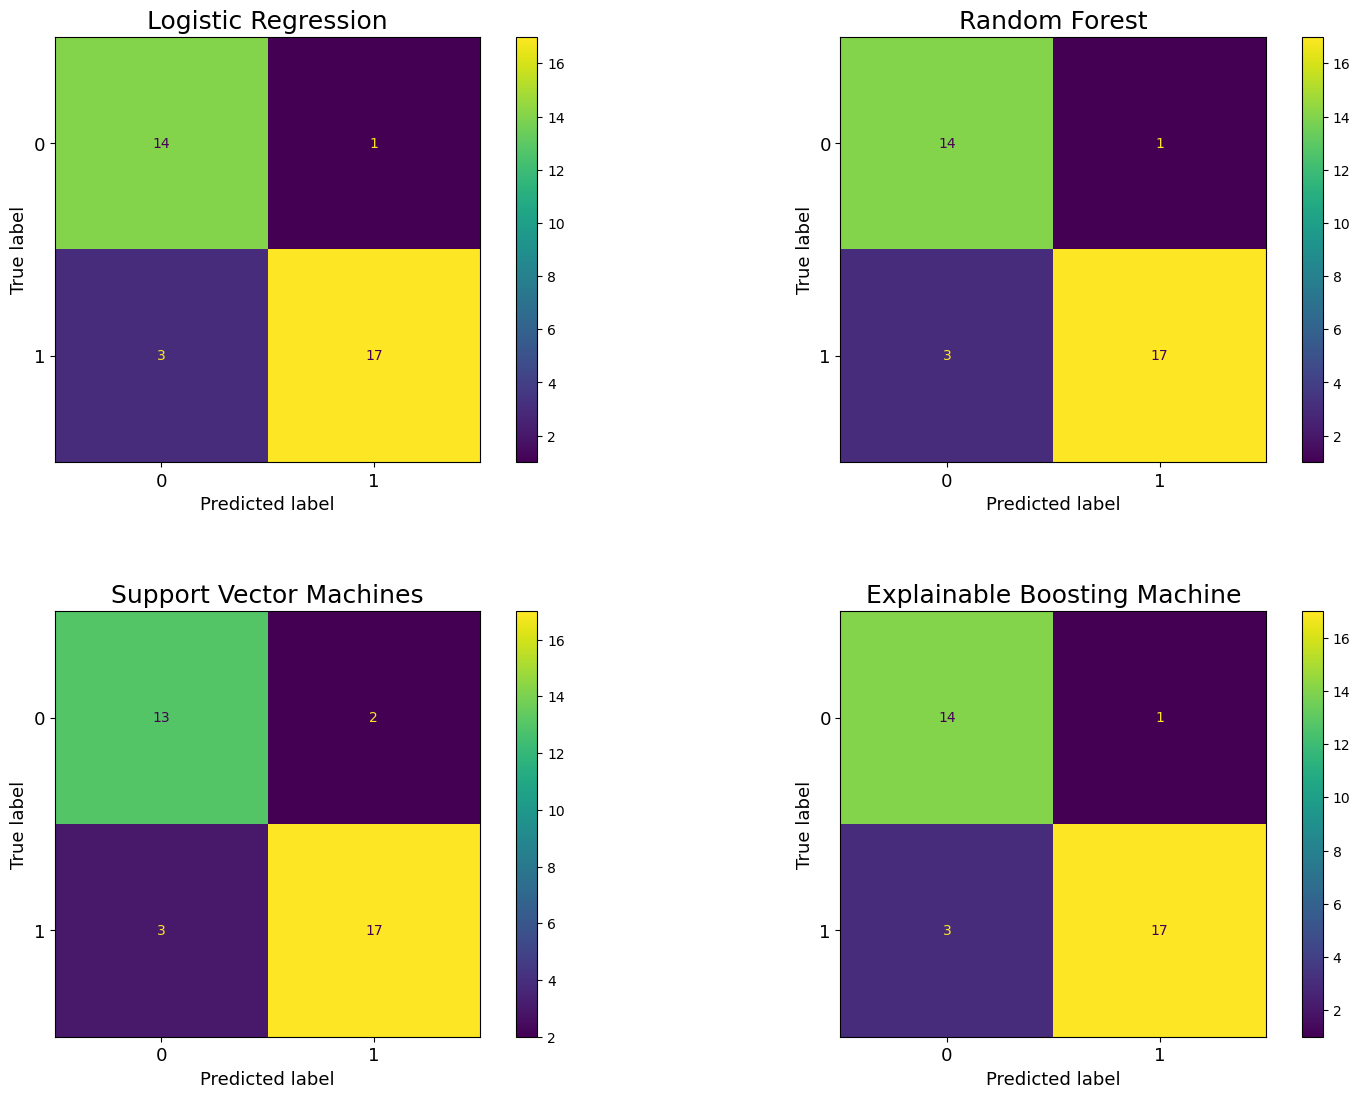

In [120]:
visual.confusion_matrices_pred([Y_test, Y_test, Y_test, Y_test], 
                          [lr_ye, rf_ye, svm_ye, ebm_ye],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"]
                          )

plt.savefig(f"{logs_dir}/darwin_conf_matrices.png", bbox_inches="tight")

plt.show()

## Curves

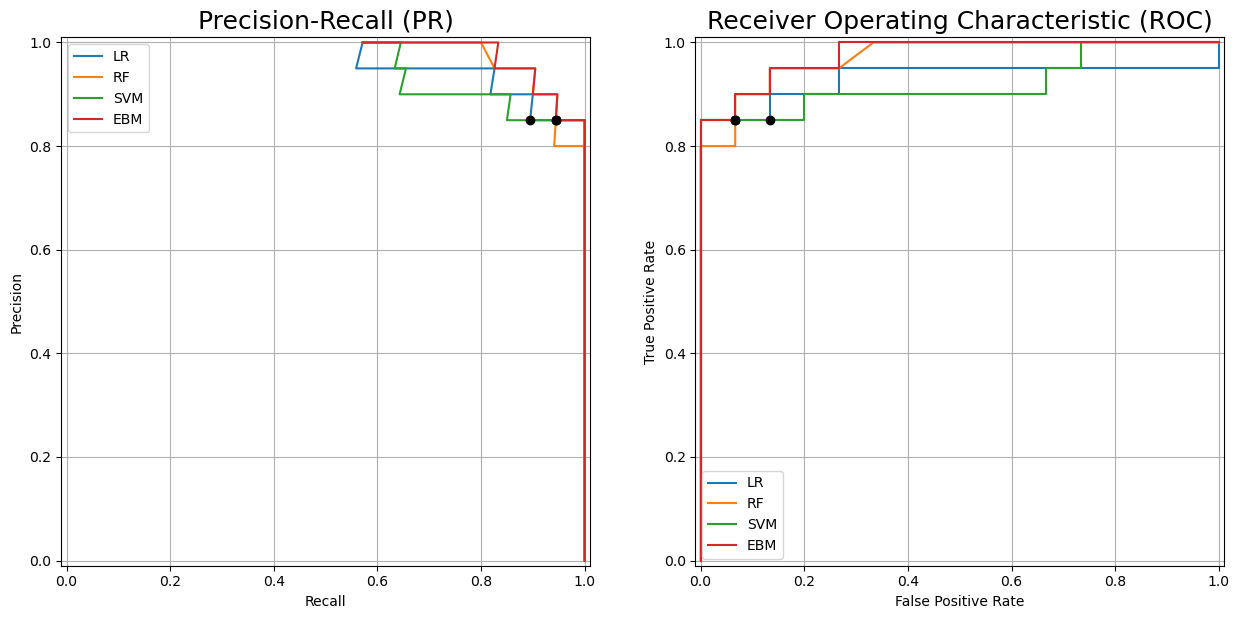

In [121]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.savefig(f"{logs_dir}/darwin_PR_ROC.png", bbox_inches="tight")
plt.show()

## Local Explanations

### LIME

In [122]:
lr_LIME_explanation.show_in_notebook(show_table=True)
lr_LIME_explanation.save_to_file(f"{logs_dir}/darwin_LR_LIME.html")

In [123]:
rf_LIME_explanation.show_in_notebook(show_table=True)
rf_LIME_explanation.save_to_file(f"{logs_dir}/darwin_RF_LIME.html")

In [124]:
svm_LIME_explanation.show_in_notebook(show_table=True)
svm_LIME_explanation.save_to_file(f"{logs_dir}/darwin_SVM_LIME.html")

### SHAP & EBM

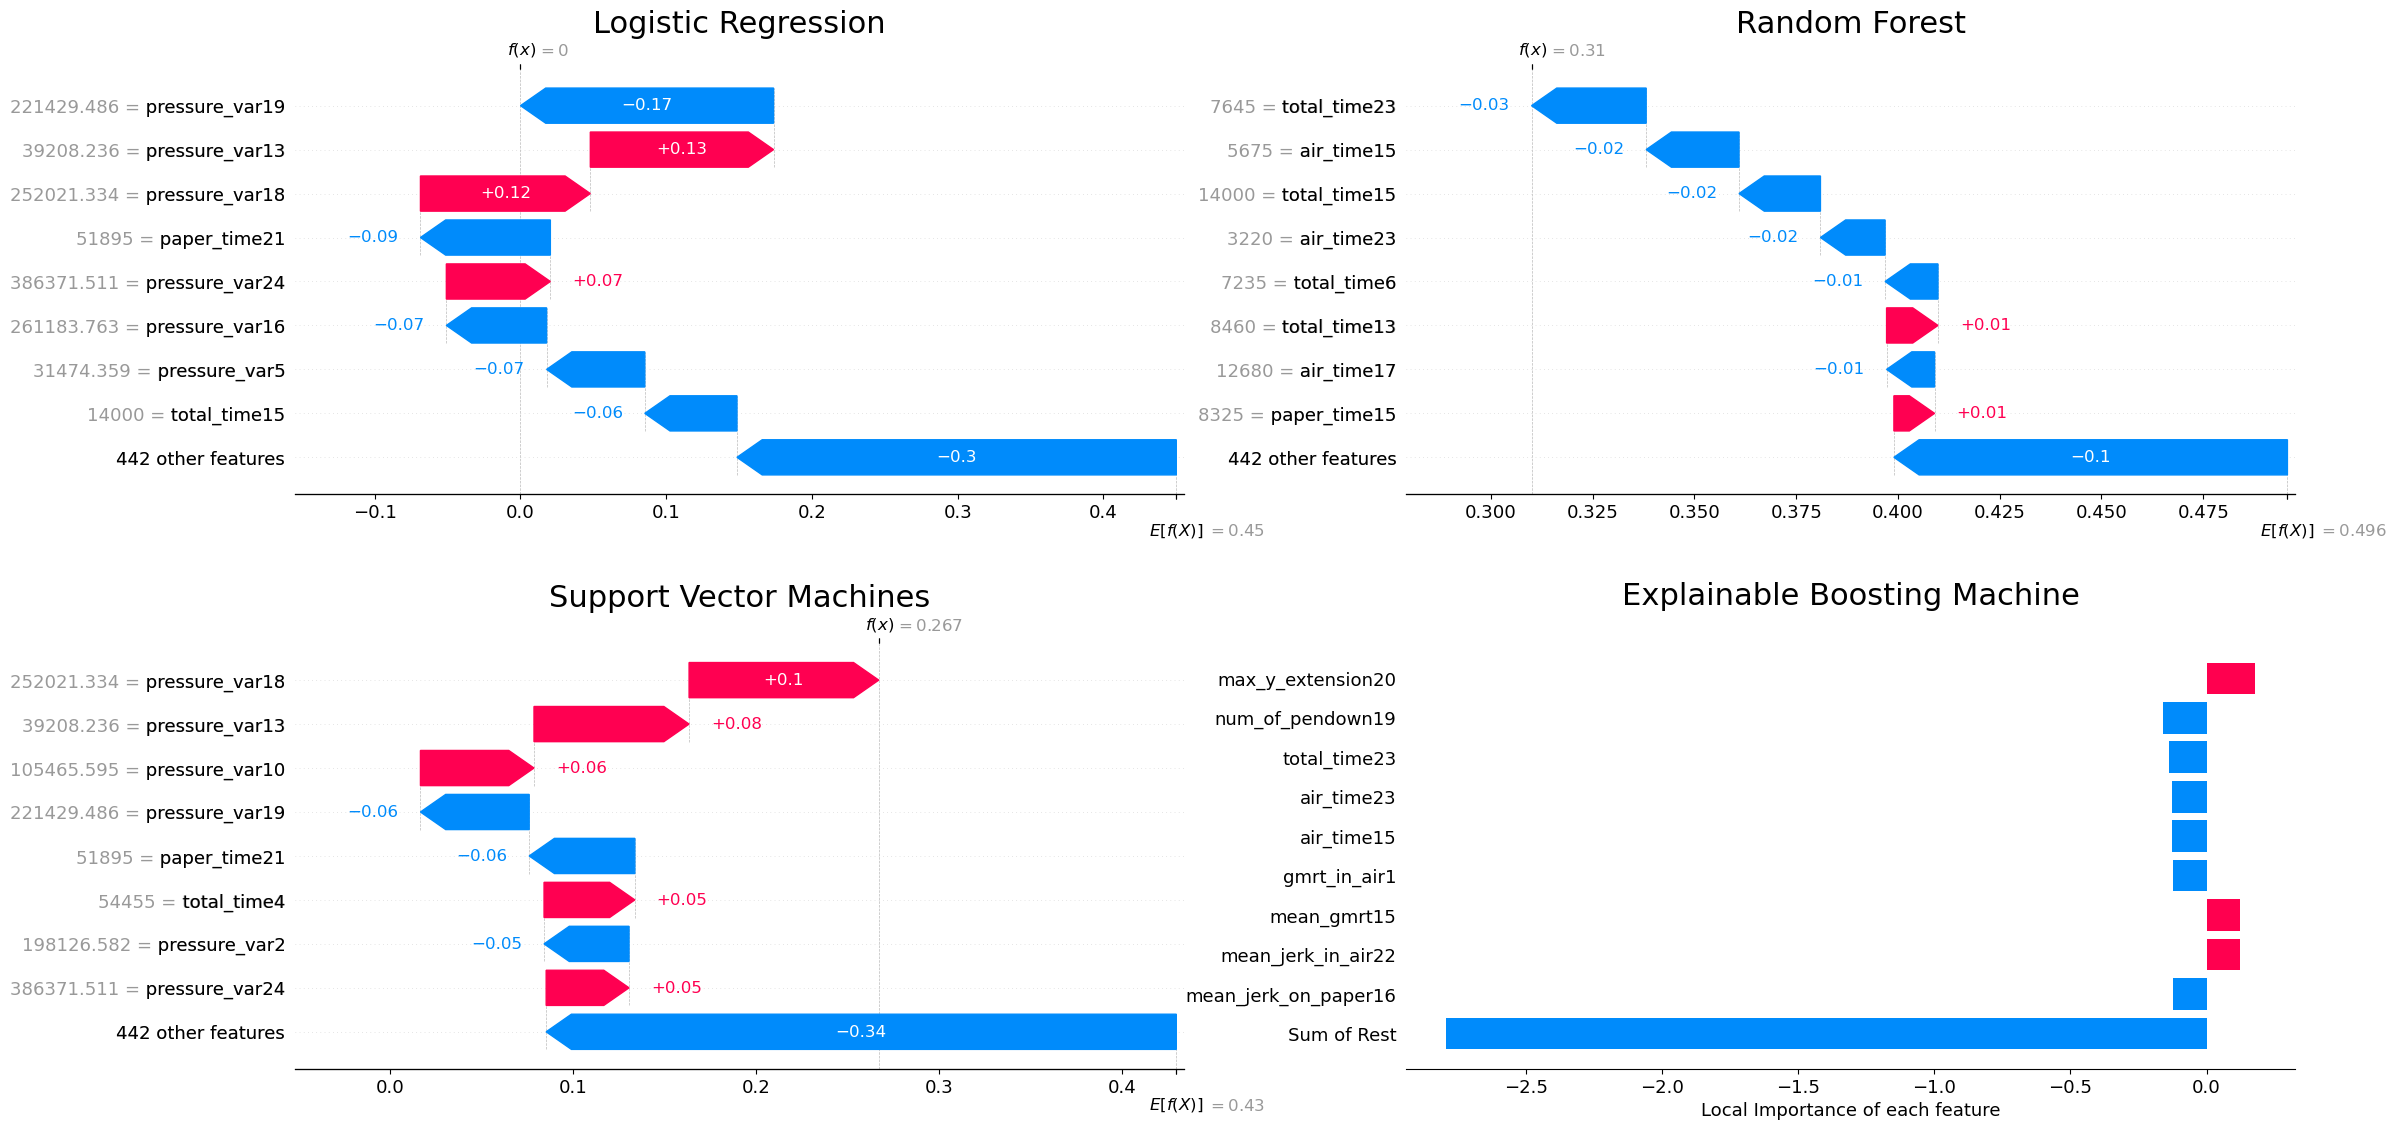

In [125]:
explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(rf_shap_loc_values[1, :], rf_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(svm_shap_loc_values[1, :], svm_SHAP_exp.expected_value[1], data=Exp_inst_pd)]

visual.local_shap(explanations, 
                  ebm_local.data(key=Exp_index),
                  nrows = 2,
                  ncols = 2,
                  figsize = (20,10),
                  title_size = 22,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255,
                  num_features=9)

plt.savefig(f"{logs_dir}/darwin_local_SHAP_EBM.png", bbox_inches="tight")

plt.show()


## Global Explanations

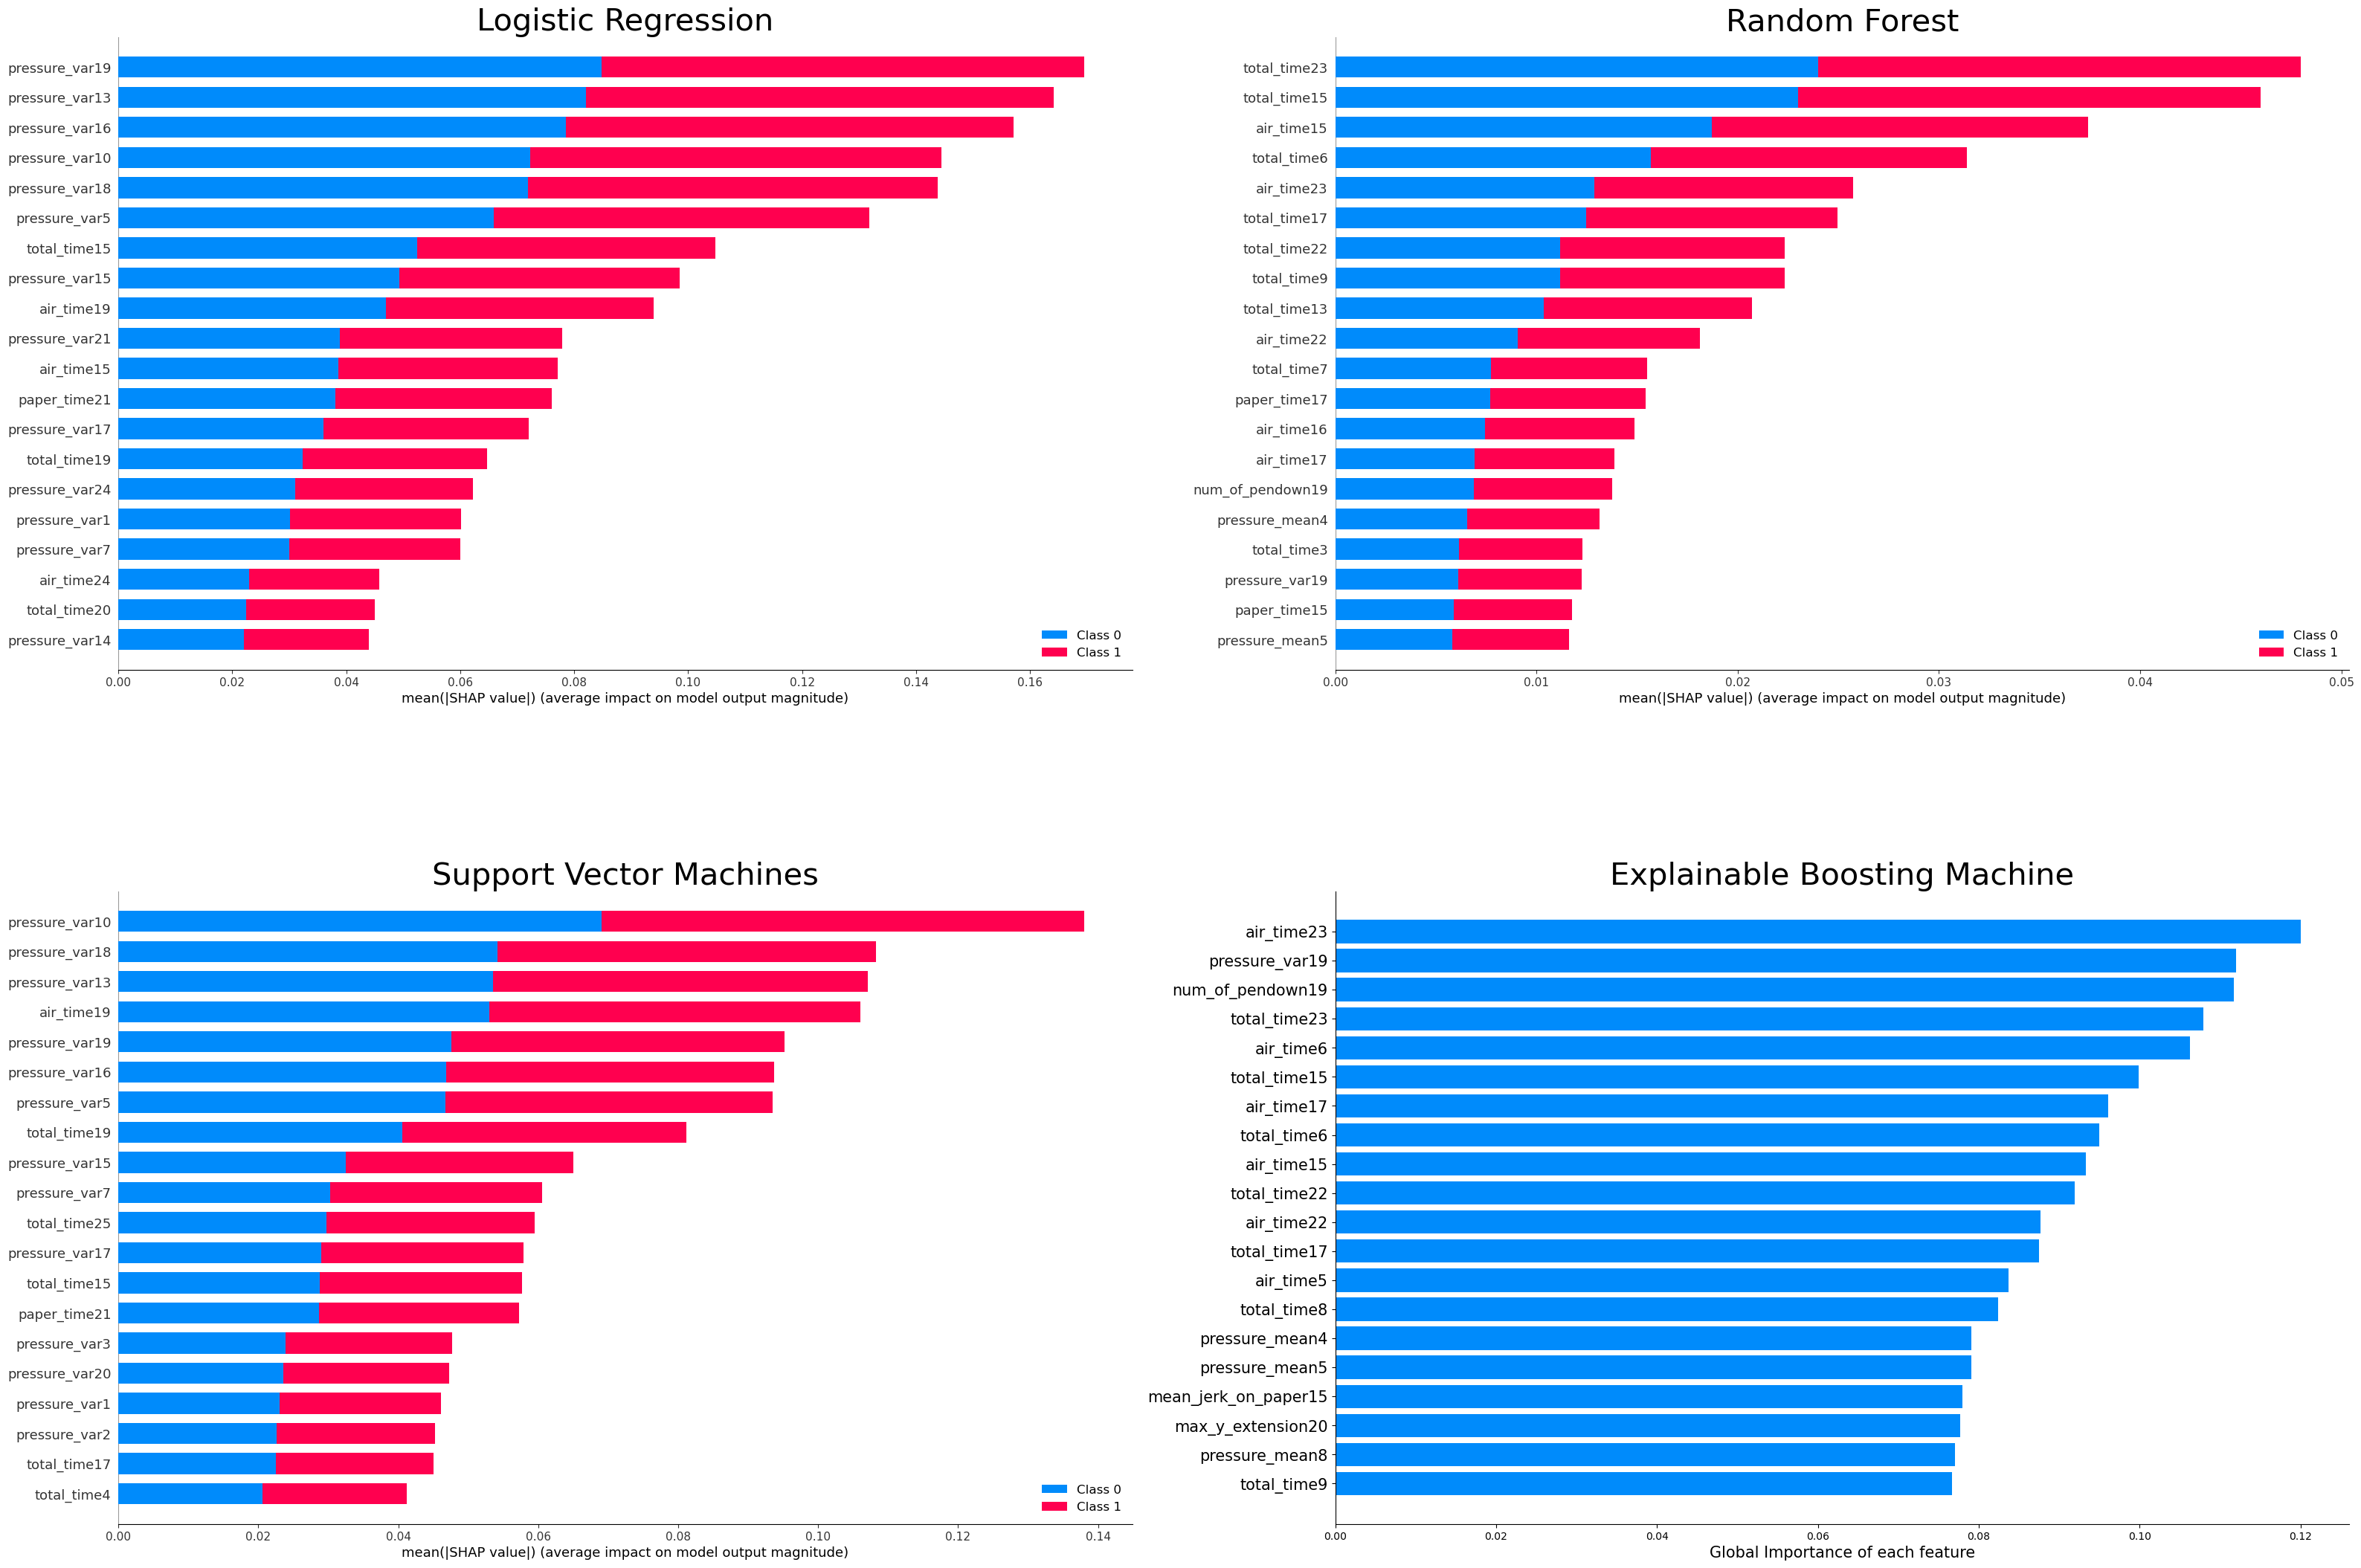

In [126]:
global_shap_values = [lr_shap_global_values,
                      rf_shap_global_values,
                      svm_shap_global_values]

visual.global_shap(global_shap_values,
                   X_test_pd,
                   ebm_global.data(),
                   nrows = 2,
                   ncols = 2,
                   figsize = (30,20),
                   title_size = 30,
                   label_size = 15,
                   titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                   ebm_colors = shap_colors/255,
                   num_features=20)

plt.savefig(f"{logs_dir}/darwin_global_SHAP_EBM.png", bbox_inches="tight")

plt.show()